# Метод наискорейшего спуска и сопряженных градиентов

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from numba import jit

## Метод наискорейшего спуска

Рассмотрим СЛУ $Ax = y$, где $A$ - SPD матрица

Положим изначально $x_1 = 0$. Определим $r_k = B - A \cdot x_k$ - вектор невязки на $k$-ой итерации. Тогда решение на $k$-ой итерации будем искать следующим образом:

$$
x_{k + 1} = x_k + \alpha_k \cdot r_k,
$$

где $\alpha_k$ - некоторый коэффициент, который находится путем минимизации $F(x_k - \alpha \cdot r_k)$ по $\alpha$ и

$$F(x) = \frac{1}{2}\langle x, x \rangle_A - x^{\top} \cdot x$$

В итоге получимм, что

$$
\alpha_k = \frac{
r^{\top}_k \cdot r_k
}{
r^{\top}_k \cdot A \cdot r_k
}\\
x_{k + 1} = x_k + \alpha_k \cdot r_k\\
r_{k + 1} = r_k - \alpha_k \cdot A \cdot r_k
$$

In [2]:
from linear_system_generators import generate_symmetric_dense_system

In [3]:
def initialize_steepest_descent(y: np.ndarray) -> np.ndarray:
    x = np.zeros_like(y)
    r = y.copy()
    return x, r


def compute_steepest_descent_single_step(
    x_curr: np.ndarray, r_curr: np.ndarray, smat: np.ndarray, eps: float = 1.0e-150
) -> (np.ndarray, np.ndarray):
    smat_dot_r = np.dot(smat, r_curr)
    alpha = np.dot(r_curr, r_curr) / max(eps, np.dot(r_curr, smat_dot_r))

    x_next = x_curr + alpha * r_curr
    r_next = r_curr - alpha * smat_dot_r
    return x_next, r_next


def compute_steepest_descent_solution(smat: np.ndarray, y: np.ndarray, num_iter: int = 1000) -> np.ndarray:
    x_curr, r_curr = initialize_steepest_descent(y=y)
    for _ in range(num_iter):
        x_curr, r_curr = compute_steepest_descent_single_step(x_curr=x_curr, r_curr=r_curr, smat=smat)
    return x_curr


def compute_steepest_descent_solution_residuals(
    smat: np.ndarray, y: np.ndarray, num_iter: int = 1000
) -> (np.ndarray, np.ndarray):
    residuals = np.zeros(num_iter)
    x_curr, r_curr = initialize_steepest_descent(y=y)
    residuals[0] = np.max(np.absolute(r_curr))
    for i in range(1, num_iter):
        x_curr, r_curr = compute_steepest_descent_single_step(x_curr=x_curr, r_curr=r_curr, smat=smat)
        residuals[i] = np.max(np.absolute(r_curr))
    return x_curr, residuals

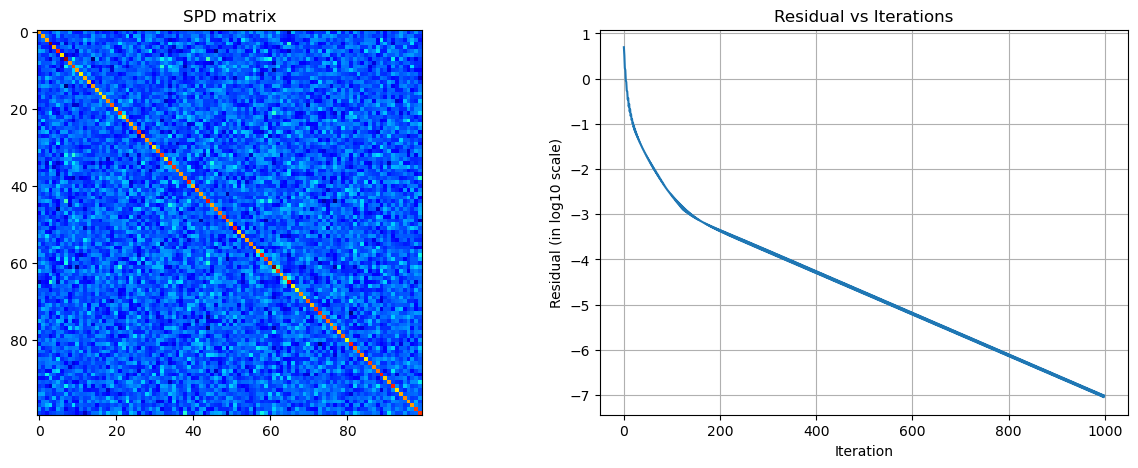

In [4]:
n = 100
smat, x_true, y = generate_symmetric_dense_system(dim=n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(smat)
ax[0].set_title('SPD matrix')

x_pred, residuals = compute_steepest_descent_solution_residuals(smat=smat, y=y, num_iter=1000)

ax[1].plot(range(len(residuals)), np.log10(residuals))
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Residual (in log10 scale)')
ax[1].set_title('Residual vs Iterations')
ax[1].grid()

plt.show()

## Метод сопряженных градиентов

Система уравнений:

$$Ax = y$$

Этот метод аналогичен предыдущему

Разница в инициализации:

$$
x_1 = 0\\
r_1 = y\\
d_1 = r_1
$$

И вычисляем $k+1$-ую итерацию следующим образом:

$$
\alpha_{k} = \frac{
\langle r_k, r_k \rangle
}{
\langle d_k, d_k \rangle_A}\\
x_{k+1} = x_{k} + \alpha_k \cdot d_k\\
r_{k+1} = r_{k} - \alpha_k \cdot A \cdot d_k\\
d_{k+1} = r_{k+1} + \frac{
\langle r_{k+1}, r_{k+1} \rangle
}{
\langle r_k, r_k \rangle
} \cdot d_k
$$


In [5]:
def initialize_conjugate_gradient(y: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    x = np.zeros_like(y)
    r = y.copy()
    d = r.copy()
    return x, r, d


def compute_conjugate_gradient_single_step(
    x_curr: np.ndarray, r_curr: np.ndarray, d_curr: np.ndarray, smat: np.ndarray, eps: float = 1.0e-150
) -> (np.ndarray, np.ndarray, np.ndarray):
    smat_dot_d = np.dot(smat, d_curr)

    alpha = np.dot(r_curr, r_curr) / max(eps, np.dot(smat_dot_d, d_curr))
    r_next = r_curr - alpha * smat_dot_d
    x_next = x_curr + alpha * d_curr
    beta = np.dot(r_next, r_next) / max(eps, np.dot(r_curr, r_curr))
    d_next = r_next + beta * d_curr
    return x_next, r_next, d_next


def compute_conjugate_gradient_solution_residuals(
    smat: np.ndarray, y: np.ndarray, num_iter: int = 1000
) -> (np.ndarray, np.ndarray):
    residuals = np.zeros(num_iter)
    x_curr, r_curr, d_curr = initialize_conjugate_gradient(y=y)
    residuals[0] = np.max(np.absolute(r_curr))
    for i in range(1, num_iter):
        x_curr, r_curr, d_curr = compute_conjugate_gradient_single_step(
            x_curr=x_curr, r_curr=r_curr, d_curr=d_curr, smat=smat
        )
        residuals[i] = np.max(np.absolute(r_curr))
    return x_curr, residuals

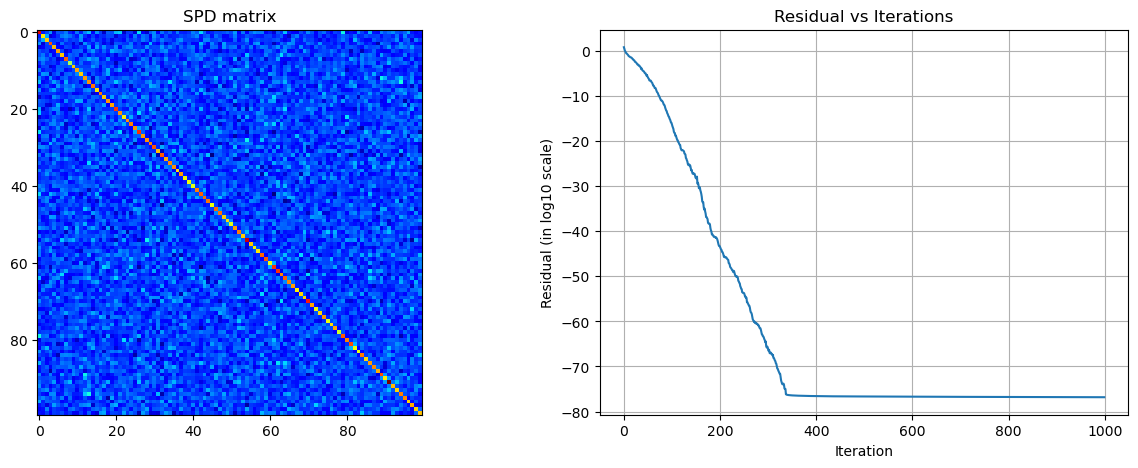

In [6]:
n = 100
smat, x_true, y = generate_symmetric_dense_system(dim=n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(smat)
ax[0].set_title('SPD matrix')

x_pred, residuals = compute_conjugate_gradient_solution_residuals(smat=smat, y=y, num_iter=1000)

ax[1].plot(range(len(residuals)), np.log10(residuals))
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Residual (in log10 scale)')
ax[1].set_title('Residual vs Iterations')
ax[1].grid()

plt.show()

Сравним теперь оба метода

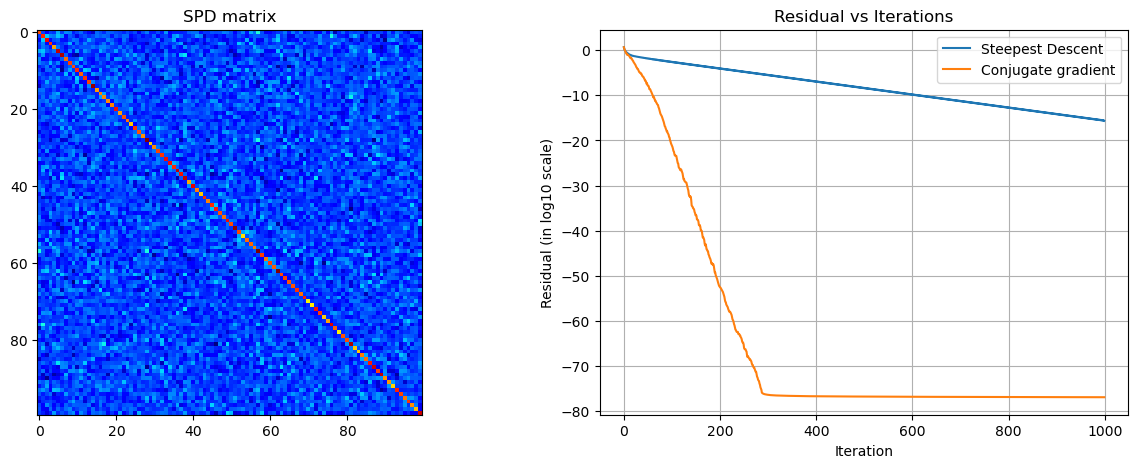

In [7]:
n = 100
smat, x_true, y = generate_symmetric_dense_system(dim=n)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(smat)
ax[0].set_title('SPD matrix')

x_pred_sd, residuals_st = compute_steepest_descent_solution_residuals(smat=smat, y=y, num_iter=1000)
x_pred_cg, residuals_cg = compute_conjugate_gradient_solution_residuals(smat=smat, y=y, num_iter=1000)

ax[1].plot(range(len(residuals_st)), np.log10(residuals_st), label='Steepest Descent')
ax[1].plot(range(len(residuals_cg)), np.log10(residuals_cg), label='Conjugate gradient')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Residual (in log10 scale)')
ax[1].set_title('Residual vs Iterations')
ax[1].grid()
ax[1].legend()

plt.show()

Видим, что метод сопряженных градиентов сходится быстрее, чем метод наискорейшего спуска

В прикладных задачах нередко возникают ситуации, когда матрица $A$ имеет очень много нулевых значений (разреженная матрица). Тогда хранить ее в обычном виде бывает затратно по потребляемой памяти. Для таких матриц существуют различные виды представлений, разберем один из них - COO (Coordinate Format), в котором храним тройки (строка, столбец, значение) для каждого ненулевого элемента

Например, матрица

$$
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 2 & 0\\
3 & 0 & 0 & 4
\end{pmatrix}
$$

будет иметь вид COO: (нумерация с $0$)
- Массив строк `row_indexes = [0, 1, 2, 2]`
- Массив столбцов `col_indexes = [0, 2, 0, 3]`
- Массив значений `values = [1, 2, 3, 4]`




Напишем теперь наши алгоритмы с разреженной матрицей

In [8]:
from linear_system_generators import generate_random_sparse_system, compute_sparse_matrix_vector_product

Метод наискорейшего спуска с разреженной матрицей

In [9]:
def initialize_steepest_descent_sparse(y: np.ndarray) -> np.ndarray:
    x = np.zeros_like(y)
    r = y.copy()
    return x, r


def compute_steepest_descent_single_step_sparse(
    x_curr: np.ndarray, r_curr: np.ndarray,
    i_idx: np.ndarray, j_idx: np.ndarray, smat: np.ndarray, eps: float = 1.0e-150
) -> (np.ndarray, np.ndarray):
    smat_dot_r = compute_sparse_matrix_vector_product(i_idx=i_idx, j_idx=j_idx, m_val=smat, v_val=r_curr)
    alpha = np.dot(r_curr, r_curr) / max(eps, np.dot(r_curr, smat_dot_r))

    x_next = x_curr + alpha * r_curr
    r_next = r_curr - alpha * smat_dot_r
    return x_next, r_next


def compute_steepest_descent_solution_sparse(
    i_idx: np.ndarray, j_idx: np.ndarray, smat: np.ndarray, y: np.ndarray, num_iter: int = 1000
) -> np.ndarray:
    x_curr, r_curr = initialize_steepest_descent_sparse(y=y)
    for _ in range(num_iter):
        x_curr, r_curr = compute_steepest_descent_single_step(
            x_curr=x_curr, r_curr=r_curr,
            i_idx=i_idx, j_idx=j_idx, smat=smat
        )
    return x_curr


def compute_steepest_descent_solution_residuals_sparse(
    i_idx: np.ndarray, j_idx: np.ndarray, smat: np.ndarray, y: np.ndarray, num_iter: int = 1000
) -> (np.ndarray, np.ndarray):
    residuals = np.zeros(num_iter)
    x_curr, r_curr = initialize_steepest_descent_sparse(y=y)
    residuals[0] = np.max(np.absolute(r_curr))
    for i in range(1, num_iter):
        x_curr, r_curr = compute_steepest_descent_single_step_sparse(
            x_curr=x_curr, r_curr=r_curr,
            i_idx=i_idx, j_idx=j_idx, smat=smat
        )
        residuals[i] = np.max(np.absolute(r_curr))
    return x_curr, residuals

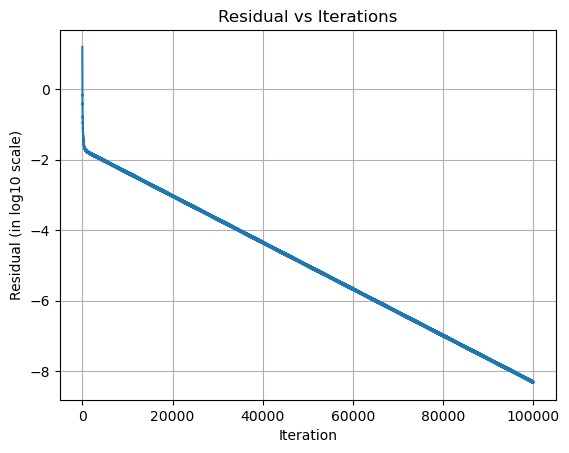

In [10]:
n = 1000
i_idx, j_idx, smat, x_true, y = generate_random_sparse_system(dim=n, frac_off_diag=0.2)

x_pred, residuals = compute_steepest_descent_solution_residuals_sparse(
    i_idx=i_idx, j_idx=j_idx, smat=smat, y=y, num_iter=100000
)

plt.plot(range(len(residuals)), np.log10(residuals))
plt.xlabel('Iteration')
plt.ylabel('Residual (in log10 scale)')
plt.title('Residual vs Iterations')
plt.grid()

plt.show()

Метод сопряженых градиентов с разреженной матрицей

In [13]:
def initialize_conjugate_gradient_sparse(y: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    x = np.zeros_like(y)
    r = y.copy()
    d = r.copy()
    return x, r, d


def compute_conjugate_gradient_single_step_sparse(
    x_curr: np.ndarray, r_curr: np.ndarray, d_curr: np.ndarray,
    i_idx: np.ndarray, j_idx: np.ndarray, smat: np.ndarray, eps: float = 1.0e-150
) -> (np.ndarray, np.ndarray, np.ndarray):
    smat_dot_d = compute_sparse_matrix_vector_product(i_idx=i_idx, j_idx=j_idx, m_val=smat, v_val=d_curr)

    alpha = np.dot(r_curr, r_curr) / max(eps, np.dot(smat_dot_d, d_curr))
    r_next = r_curr - alpha * smat_dot_d
    x_next = x_curr + alpha * d_curr
    beta = np.dot(r_next, r_next) / max(eps, np.dot(r_curr, r_curr))
    d_next = r_next + beta * d_curr
    return x_next, r_next, d_next


def compute_conjugate_gradient_solution_residuals_sparse(
    i_idx: np.ndarray, j_idx: np.ndarray, smat: np.ndarray, y: np.ndarray, num_iter: int = 1000
) -> (np.ndarray, np.ndarray):
    residuals = np.zeros(num_iter)
    x_curr, r_curr, d_curr = initialize_conjugate_gradient_sparse(y=y)
    residuals[0] = np.max(np.absolute(r_curr))
    for i in range(1, num_iter):
        x_curr, r_curr, d_curr = compute_conjugate_gradient_single_step_sparse(
            x_curr=x_curr, r_curr=r_curr, d_curr=d_curr,
            i_idx=i_idx, j_idx=j_idx, smat=smat
        )
        residuals[i] = np.max(np.absolute(r_curr))
    return x_curr, residuals

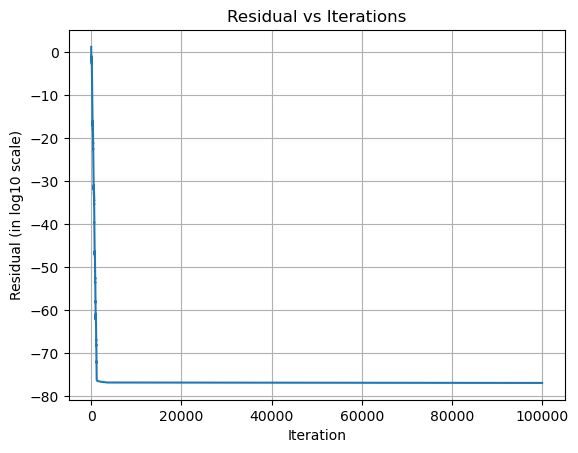

In [14]:
n = 1000
i_idx, j_idx, smat, x_true, y = generate_random_sparse_system(dim=n, frac_off_diag=0.2)

x_pred, residuals = compute_conjugate_gradient_solution_residuals_sparse(
    i_idx=i_idx, j_idx=j_idx, smat=smat, y=y, num_iter=100000
)

plt.plot(range(len(residuals)), np.log10(residuals))
plt.xlabel('Iteration')
plt.ylabel('Residual (in log10 scale)')
plt.title('Residual vs Iterations')
plt.grid()

plt.show()